In [ ]:
# script to generate hypotheses summary


In [2]:
import sys

modelkey = 3
sys.argv = [f"--modelversion {modelkey}"]

from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn import utils
import pandas as pd
import scipy.stats as stats
import seaborn as sns

import config.config as cc
from Functions import metrics
import numpy as np
import Functions.evaluation as ev
from sklearn.datasets import fetch_openml

from Functions.dataprep import SpecificPrep, CommonPrep

% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = fetch_openml(data_id=41214, as_frame=True).data
common = CommonPrep()
train0, _, test0 = common.fit_transform(df)

# Other Section Plots

In [ ]:
sns.set(rc={'figure.figsize': (3, 1)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params)
df1 = df.copy(deep=True).loc[df['Exposure'] <= 1]
ax = sns.histplot(df1['Exposure'], bins=10)
ax.set(ylabel='N')

In [ ]:
df1 = df.copy(deep=True).loc[df['ClaimNb'] <= 4]
df1['Claim Count (ClaimNb)'] = df1['ClaimNb']
ax = sns.histplot(df1['Claim Count (ClaimNb)'])
ax.set(ylabel='N')


In [9]:
cc.metadata_ei = cc.load_metadata(metadata_path='./config/metadata.json')
cc.metadata_noei = cc.load_metadata(metadata_path='./config/metadata_noei.json')

In [ ]:
datasets = {
    'ei': SpecificPrep(variables=cc.metadata_ei['variables'], gan_cats=cc.metadata_ei['cats_vars_gan'],
                       xgb_cats=cc.metadata_ei['cats_vars_xgb'], addei=True,
                       columns_to_scale=cc.metadata_ei['standardized_vars']),
    'noei': SpecificPrep(variables=cc.metadata_noei['variables'], gan_cats=cc.metadata_noei['cats_vars_gan'],
                         xgb_cats=cc.metadata_noei['cats_vars_xgb'], addei=False,
                         columns_to_scale=cc.metadata_noei['standardized_vars'])
}

for key, trans in datasets.items():
    train = train0.copy(deep=True)
    test = test0.copy(deep=True)

    trans = trans.fit(train)
    train = trans.transform(train)
    test = trans.transform(test)

    train = trans.inverse_transform(train)
    test = trans.inverse_transform(test)

    datasets[key] = {
        'train': train,
        'test': test,
        'transformer': trans
    }

In [7]:
# import os
# # Use to find best model
# models = []
# losses_best = []
# losses_final = []
# for f in os.listdir('./data/losses/'):
#     df = pd.read_csv('./data/losses/'+f)
#     models += [f]
#     losses_best += [df.loc[df['metric_name'] == 'Generated Poisson', 'metric_value'].min()]
#     losses_final += [df.loc[df['metric_name'] == 'Generated Poisson', 'metric_value'].iloc[-1]]


# modelslosses = pd.DataFrame({'model': models, 'minloss': losses_best, 'finloss': losses_final})
# modelslosses.sort_values('finloss').head(50)


# Which XGBoost to use

In [20]:
BOOTSTRAPS = 100

In [ ]:
xgb_v1 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 500000, version=1)
xgb_v2 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 500000, version=2)
[[ev.summaries(x) for x in xgb_v1],
 [ev.summaries(x) for x in xgb_v2]]

In [ ]:
xgb_v1 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 5000, version=1)
xgb_v2 = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 5000, version=2)
[[ev.summaries(x) for x in xgb_v1],
 [ev.summaries(x) for x in xgb_v2]]

Best models:
L: V1
S: V2

# Get GANs

In [22]:
bestmodels['l_ei']['boots'] = ev.gan_bootstraped(bestmodels['l_ei'], datasets['noei']['test'], datasets, BOOTSTRAPS)
ev.summaries(bestmodels['l_ei']['boots'])


100%|██████████| 100/100 [23:29<00:00, 14.10s/it]


(0.331, 0.012, 0.328, 0.333)

In [14]:
bestmodels = {
    'l_ei': ev.get_model(22, datasets, bestmodel=True),  # 22
    'l_noei': ev.get_model(122, datasets, bestmodel=True),  # 104
    's_ei': ev.get_model(721, datasets, bestmodel=True),  # 721
    's_noei': ev.get_model(621, datasets, bestmodel=True)  # 621
}

bestmodels['l_ei']['boots'] = ev.gan_bootstraped(bestmodels['l_ei'], datasets['noei']['test'], datasets, BOOTSTRAPS)
bestmodels['l_noei']['boots'] = ev.gan_bootstraped(bestmodels['l_noei'], datasets['noei']['test'], datasets, BOOTSTRAPS)
bestmodels['s_ei']['boots'] = ev.gan_bootstraped(bestmodels['s_ei'], datasets['noei']['test'], datasets, BOOTSTRAPS,
                                                 version=2)
bestmodels['s_noei']['boots'] = ev.gan_bootstraped(bestmodels['s_noei'], datasets['noei']['test'], datasets, BOOTSTRAPS,
                                                   version=2)


KeyboardInterrupt: 

In [15]:
[
    [ev.summaries(bestmodels['l_ei']['boots'])],
    [ev.summaries(bestmodels['l_noei']['boots'])],
    [ev.summaries(bestmodels['s_ei']['boots'])],
    [ev.summaries(bestmodels['s_noei']['boots'])]
]

KeyError: 'boots'

# Hypothesis 1.1

In [274]:
devs = []
aucs = []

for i in range(0, BOOTSTRAPS):
    train1 = utils.resample(datasets['noei']['train'], replace=True, n_samples=len(datasets['noei']['train']),
                            random_state=i, stratify=None)
    test1 = utils.resample(datasets['noei']['test'], replace=True, n_samples=len(datasets['noei']['test']),
                           random_state=i, stratify=None)

    pred_dummy = datasets['noei']['train']['ClaimNb'].mean()

    preds1 = [pred_dummy for x in test1['ClaimNb']]
    devs += [metrics.poisson_deviance(preds1, test1['ClaimNb'])]
    aucs += [roc_auc_score(test1['ClaimNb'] >= 1, preds1)]

base_devs = devs
base_aucs = aucs

[
    ev.summaries(devs),
    ev.summaries(aucs)
]

[(31.909, 0.279, 31.853, 31.965), (0.5, 0.0, nan, nan)]

In [275]:
stats.ttest_ind(bestmodels['l_noei']['boots'][0], base_devs, alternative='less')

[Ttest_indResult(statistic=5.560431930551993, pvalue=0.9999999568204301)]

# Hypothesis 1.2

In [22]:
xgb_l = ev.xgb_bootstraped(datasets['noei']['train'], datasets['noei']['test'], BOOTSTRAPS, 500000, version=1)
[ev.summaries(x) for x in xgb_l]

[(30.161, 0.272, 30.107, 30.215), (0.655, 0.003, 0.655, 0.656)]

In [18]:
stats.ttest_ind(bestmodels['l_ei']['boots'][0], xgb_l[0], alternative='two-sided')

[Ttest_indResult(statistic=-40.51061010409249, pvalue=8.937878652662032e-98),
 Ttest_indResult(statistic=6.0209612362247125, pvalue=8.285081527422289e-09)]

# Hypothesis 2.1

In [20]:
stats.ttest_ind(bestmodels['l_ei']['boots'][0], bestmodels['l_noei']['boots'][0], alternative='less')

[Ttest_indResult(statistic=-6.876804220446367, pvalue=3.911041636262372e-11),
 Ttest_indResult(statistic=0.5482921270041329, pvalue=0.29205449117704385)]

# Hypothesis 2.2

In [25]:
stats.ttest_ind(bestmodels['s_ei']['boots'][0], bestmodels['s_noei']['boots'][0], alternative='less')

[Ttest_indResult(statistic=38.533550974530705, pvalue=1.0),
 Ttest_indResult(statistic=-45.24884934080125, pvalue=1.0)]

# Plots

## Results Boxplot

In [239]:
sns.set(rc={'figure.figsize': (5, 4)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

<Axes: xlabel='Model type', ylabel='Poisson Deviance'>

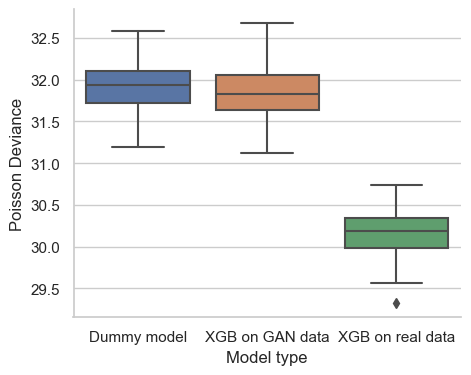

In [240]:
toplot = pd.DataFrame()

#H1
toplot = pd.concat([toplot, pd.DataFrame({'N': 433728, 'Model type': 'Dummy model', 'Poisson Deviance': base_devs})])
toplot = pd.concat([toplot, pd.DataFrame(
    {'N': 433728, 'Model type': 'XGB on GAN data', 'Poisson Deviance': bestmodels['l_ei']['boots'][0]})])
toplot = pd.concat(
    [toplot, pd.DataFrame({'N': 433728, 'Model type': 'XGB on real data', 'Poisson Deviance': xgb_l[0]})])

sns.boxplot(data=toplot, x='Model type', y='Poisson Deviance')

In [232]:
sns.set(rc={'figure.figsize': (3, 4)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

<Axes: xlabel='N', ylabel='Poisson Deviance'>

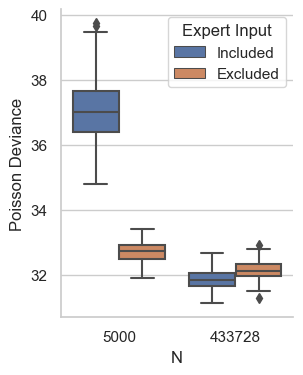

In [233]:
# H2
toplot = pd.concat([toplot, pd.DataFrame(
    {'N': 433728, 'Expert Input': 'Included', 'Poisson Deviance': bestmodels['l_ei']['boots'][0]})])
toplot = pd.concat([toplot, pd.DataFrame(
    {'N': 433728, 'Expert Input': 'Excluded', 'Poisson Deviance': bestmodels['l_noei']['boots'][0]})])
toplot = pd.concat(
    [toplot, pd.DataFrame({'N': 5000, 'Expert Input': 'Included', 'Poisson Deviance': bestmodels['s_ei']['boots'][0]})])
toplot = pd.concat([toplot, pd.DataFrame(
    {'N': 5000, 'Expert Input': 'Excluded', 'Poisson Deviance': bestmodels['s_noei']['boots'][0]})])

sns.boxplot(data=toplot, x='N', hue='Expert Input', y='Poisson Deviance')

## Decile Plot

In [270]:
preds_l_ei = ev.gan_xgb(metadata=cc.metadata_ei, postprocess=True, testset=datasets['noei']['test'],
                        transformer=datasets['ei']['transformer'], value=bestmodels['l_ei'])
preds_l_noei = ev.gan_xgb(metadata=cc.metadata_noei, postprocess=True, testset=datasets['noei']['test'],
                          transformer=datasets['noei']['transformer'], value=bestmodels['l_noei'])
preds_s_ei = ev.gan_xgb(metadata=cc.metadata_ei, postprocess=True, testset=datasets['noei']['test'],
                        transformer=datasets['ei']['transformer'], value=bestmodels['s_ei'])
preds_s_noei = ev.gan_xgb(metadata=cc.metadata_noei, postprocess=True, testset=datasets['noei']['test'],
                          transformer=datasets['noei']['transformer'], value=bestmodels['s_noei'])

In [271]:
sns.set(rc={'figure.figsize': (4, 2)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

<Axes: xlabel='Decile', ylabel='Mean Error'>

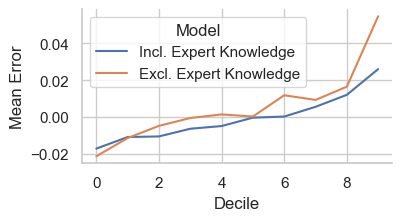

In [272]:
plottest = datasets['noei']['test'].copy(deep=True)
plottest['lei'] = preds_l_ei
plottest['lnoei'] = preds_l_noei
plottest['sei'] = preds_s_ei
plottest['snoei'] = preds_s_noei
plottest['dec_lei'] = pd.qcut(plottest['lei'], q=10, labels=False)
plottest['dec_lnoei'] = pd.qcut(plottest['lnoei'], q=10, labels=False)
plottest['risk_lei'] = (plottest['lei'] - plottest['ClaimNb'])
plottest['risk_lnoei'] = (plottest['lnoei'] - plottest['ClaimNb'])
plottestlei = plottest.groupby('dec_lei', as_index=False)['risk_lei'].mean()
plottestlnoei = plottest.groupby('dec_lnoei', as_index=False)['risk_lnoei'].mean()
plottestlei.columns = ['Decile', 'Mean Error']
plottestlei['Model'] = 'Incl. Expert Knowledge'
plottestlnoei.columns = ['Decile', 'Mean Error']
plottestlnoei['Model'] = 'Excl. Expert Knowledge'
toplot = pd.concat([plottestlei, plottestlnoei])

sns.lineplot(data=toplot, x="Decile", y="Mean Error", hue="Model")


<Axes: xlabel='Decile', ylabel='Mean Error'>

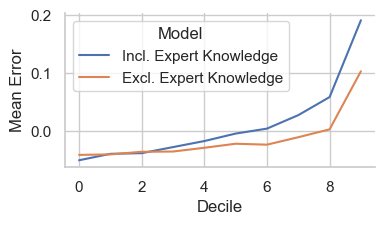

In [273]:
plottest = datasets['noei']['test'].copy(deep=True)
plottest['lei'] = preds_s_ei
plottest['lnoei'] = preds_s_noei
plottest['dec_lei'] = pd.qcut(plottest['lei'], q=10, labels=False)
plottest['dec_lnoei'] = pd.qcut(plottest['lnoei'], q=10, labels=False)
plottest['risk_lei'] = (plottest['lei'] - plottest['ClaimNb'])
plottest['risk_lnoei'] = (plottest['lnoei'] - plottest['ClaimNb'])
plottestlei = plottest.groupby('dec_lei', as_index=False)['risk_lei'].mean()
plottestlnoei = plottest.groupby('dec_lnoei', as_index=False)['risk_lnoei'].mean()
plottestlei.columns = ['Decile', 'Mean Error']
plottestlei['Model'] = 'Incl. Expert Knowledge'
plottestlnoei.columns = ['Decile', 'Mean Error']
plottestlnoei['Model'] = 'Excl. Expert Knowledge'
toplot = pd.concat([plottestlei, plottestlnoei])

sns.lineplot(data=toplot, x="Decile", y="Mean Error", hue="Model")

In [114]:
# devs, maes, rmses, ginis
[
    np.mean(x[0]) for x in bestmodels.values()
]

[31.457299999999996, 31.5355, 35.8653, 31.4419, 37.214299999999994, 32.7136]

In [89]:
#     gan_bootstraped(finalmodels['l_ei'], datasets['noei']['test'], BOOTSTRAPS),
#     gan_bootstraped(finalmodels['l_noei'], datasets['noei']['test'], BOOTSTRAPS)


KeyboardInterrupt

